# **Time Series Forecasting with RNNs and GRUs**
*In this exercise, we implement and compare recurrent neural network models for time series prediction.*

You can ask your questions in Telegram : @FatemehNikkhoo


Name = "Seyyed Amirmahdi Sadrzadeh"

StudentId = "401102015"

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Set up device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Deep/HW3/airline_passengers.csv', header=0)#, parse_dates=['Month'])

# Preprocessing pipeline:
#   1. Inspect the data
#   2. Remove duplicates
#   3. Handle missing values
#   4. Train/Val/Test split
#   5. Normalize features
#   6. Apply sliding windows to create (X, y) sequences

# 1. Inspect the Data

In [6]:
# 1. Data Inspection

# Summary statistics of the dataset
print("Summary Statistics:")
print(df.describe(), "\n")
# Inspect the first few rows, dataset columns(features), data types, and shape
print("Dataset Overview:")
print(df.head(), "\n")
print("Dataset Columns:", df.columns)
print("Dataset Data Types:", df.dtypes)
print("Dataset Shape:", df.shape)

Summary Statistics:
       Passengers
count  166.000000
mean   280.650602
std    114.890771
min    104.000000
25%    191.000000
50%    264.000000
75%    355.750000
max    622.000000 

Dataset Overview:
     Month  Passengers
0  1949-01       112.0
1  1949-02       118.0
2  1949-03       132.0
3  1949-04       129.0
4  1949-05         NaN 

Dataset Columns: Index(['Month', 'Passengers'], dtype='object')
Dataset Data Types: Month          object
Passengers    float64
dtype: object
Dataset Shape: (174, 2)


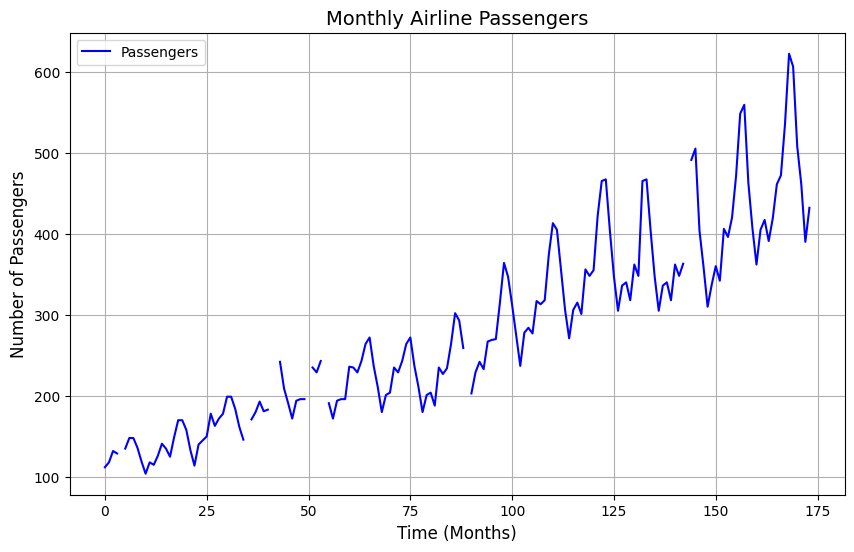

In [7]:
# Plot the original 'Passengers' data
plt.figure(figsize=(10, 6))
plt.plot(df['Passengers'], label='Passengers', color='b')

# Set title and labels
plt.title('Monthly Airline Passengers', fontsize=14)
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

# Show gridlines
plt.grid(True)
# Show legend
plt.legend()
# Display the plot
plt.show()

# 2. Remove Duplicates

In [8]:
# TODO: Check for duplicate rows in the dataset
duplicates = df.duplicated().sum()  # Count total duplicate rows
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    # TODO: Remove duplicate rows
    df = df.drop_duplicates()  # Drop duplicate rows from the DataFrame
    print(f"Removed {duplicates} duplicate rows.")
else:
    print("No duplicates found.")


Number of duplicate rows: 28
Removed 28 duplicate rows.


# 3. Handle Missing Values

In [10]:
# TODO: Check for missing values in each column
missing_values = df.isnull().sum()  # Total missing values per column
missing_values_percentage = (missing_values / len(df)) * 100  # Percentage of missing values per column

print(f"Missing values per column:\n{missing_values}")
print(f"Percentage of missing values per column:\n{missing_values_percentage}\n")

if missing_values.sum() > 0:
    # TODO: Impute missing values with the column mean (only for numeric columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns  # Get only numeric columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())  # Fill missing values in numeric columns
    print("Missing values have been imputed with the column mean.")
else:
    print("No missing values found.")


Missing values per column:
Month         0
Passengers    8
dtype: int64
Percentage of missing values per column:
Month         0.000000
Passengers    5.479452
dtype: float64

Missing values have been imputed with the column mean.


# 4. Train/Val/Test split

### Question:
**What is data leakage in time series forecasting, and how can you prevent it when splitting data for training, validation, and testing?**


In time series forecasting, **data leakage** refers to the situation where information from the future (which wouldn't realistically be available during prediction) is used to train the model. This gives the model an unfair advantage during training, which leads to overfitting and results that don't generalize well to real-world scenarios.

Unlike regular machine learning tasks where shuffling is common, time series data is sequential — the order matters. So to prevent data leakage, it's important to **maintain the chronological order** when splitting the dataset. Typically, we divide the data into three parts:  
- **Training set:** the earliest portion of the timeline  
- **Validation set:** the middle part  
- **Test set:** the most recent data  

To avoid leakage:
- I make sure to **split the data in order**, without random shuffling.
- When using scalers like `MinMaxScaler`, I only **fit them on the training data** and then apply them to the validation and test sets. This ensures that future values don't influence earlier transformations.
- I also avoid using any features or signals that would require knowledge of future data at prediction time.

In short, the key idea is to simulate how the model would behave in a real deployment: using only **past data to predict the future**.


In [11]:
# 4. Train, Validation, and Test Split
print("Splitting data into training, validation, and testing sets...")

def dataset_split(data):
    """This function splits the dataset into
    training, validation, and testing sets and returns them."""

    # TODO: Split the data into training and testing sets (80% training, 20% testing)
    test_size = int(len(data) * 0.2)
    test_data = data[-test_size:]           # Last 20% for testing
    train_val_data = data[:-test_size]      # First 80% for training + validation

    # TODO: Now split the training data into training and validation sets (80% training, 20% validation)
    val_size = int(len(train_val_data) * 0.2)
    val_data = train_val_data[-val_size:]   # Last 20% of train_val_data for validation
    train_data = train_val_data[:-val_size] # Remaining 80% for training

    print(f"Training data shape: {train_data.shape}")
    print(f"Validation data shape: {val_data.shape}")
    print(f"Testing data shape: {test_data.shape}\n")

    return train_data, val_data, test_data

# Split the data using the function
data = df['Passengers'].values
train_data, val_data, test_data = dataset_split(data)


Splitting data into training, validation, and testing sets...
Training data shape: (94,)
Validation data shape: (23,)
Testing data shape: (29,)



# 5. Normalize features

In [12]:
# 5. Normalize the Data
print("Normalizing the data...")

# Initialize the scaler
scaler = MinMaxScaler()  # Feature scaling between 0 and 1

# TODO: Normalize the training data
train_data = train_data.reshape(-1, 1)  # Reshape for scaler input
train_data_scaled = scaler.fit_transform(train_data)  # Fit and scale only on training data

# TODO: Normalize the validation data using the same scaler
val_data = val_data.reshape(-1, 1)
val_data_scaled = scaler.transform(val_data)  # Use same scaler (don't fit again)

# TODO: Normalize the test data using the same scaler
test_data = test_data.reshape(-1, 1)
test_data_scaled = scaler.transform(test_data)  # Use same scaler (don't fit again)

# Note: You can also try other scaling techniques like StandardScaler
# For example:
# scaler = StandardScaler()  # Standard scaling (zero mean, unit variance)

print("Data normalization complete.\n")


Normalizing the data...
Data normalization complete.



# 6. Apply sliding windows to create (X, y) sequences

In [13]:
# 6. Apply Windowing to Create (X, y) Pairs
print("Creating time-series windows (X, y) pairs...")

def create_dataset(dataset, look_back=10):
    """This function creates (X, y) pairs where:
          X is a time series with length 'look_back' and
          y is the next value to predict."""

    X, y = [], []
    for i in range(len(dataset) - look_back):
        # TODO: Create the window (X) and target (y)
        X.append(dataset[i:i + look_back])       # A sequence of look_back values
        y.append(dataset[i + look_back])         # The value right after the window

    return np.array(X), np.array(y)

look_back = 5  # Window length used to predict future

# Create sequences for training, validation, and testing data
X_train, y_train = create_dataset(train_data_scaled, look_back)
X_val, y_val = create_dataset(val_data_scaled, look_back)
X_test, y_test = create_dataset(test_data_scaled, look_back)

print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_val:   {X_val.shape}, Shape of y_val: {y_val.shape}")
print(f"Shape of X_test:  {X_test.shape}, Shape of y_test: {y_test.shape}")


Creating time-series windows (X, y) pairs...
Shape of X_train: (89, 5, 1), Shape of y_train: (89, 1)
Shape of X_val:   (18, 5, 1), Shape of y_val: (18, 1)
Shape of X_test:  (24, 5, 1), Shape of y_test: (24, 1)


# Convert Data to PyTorch Tensors and Create DataLoaders

In [14]:
# Convert numpy arrays to PyTorch tensors (dtype=float32 is required for neural networks)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Wrap tensors into TensorDataset objects for structured access
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

# Set batch size for training
batch_size = 32

# Create DataLoaders for training, validation, and testing
# shuffle=True only for training to randomize batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoader setup complete.\n")

DataLoader setup complete.



# Define RNN Model

In [15]:
# Define RNN Model for Time Series Regression
class RNNModel(nn.Module):
    """
    A Recurrent Neural Network (RNN) for time series regression.
    This model predicts a single future value based on a sequence of past values.
    """
    def __init__(self, input_size, hidden_size=50, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        # TODO: define RNN and output layer
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer (batch_first=True so input shape is (batch, seq, feature))
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass of the model
            - x: input tensor of shape (batch_size, seq_length, input_size)
            - returns : output of final linear layer
        """
        # TODO: forward pass of the model

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # RNN forward pass
        out, _ = self.rnn(x, h0)  # out shape: (batch, seq_len, hidden_size)

        # Take only the output from the final time step
        out = self.fc(out[:, -1, :])  # shape: (batch, output_size)

        return out


# Training Function

In [16]:
def train_model(model, train_loader, val_loader=None, epochs=20, learning_rate=0.001, device='cpu', patience=5):
    """
    Model Training Function with Validation and Early Stopping

    Args:
    - model: PyTorch model to train
    - train_loader: DataLoader for the training set
    - val_loader: DataLoader for the validation set
    - epochs: Number of epochs to train
    - learning_rate: Learning rate for the optimizer
    - device: Device to run the model on ('cpu' or 'cuda')
    - patience: Early stopping patience (number of epochs without improvement to stop training)

    Returns:
    - train_loss_history: List of average training losses per epoch
    - val_loss_history:   List of average validation losses per epoch
    """

    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # TODO: Define a proper loss function for regression task
    loss_fn = nn.MSELoss()  # Mean Squared Error is suitable for regression

    # Store loss values for tracking
    train_loss_history = []
    val_loss_history = []

    # Move the model to the specified device (GPU or CPU)
    model.to(device)

    # TODO: Set the model to training mode
    model.train()

    # Initialize early stopping parameters
    best_val_loss = float('inf')  # Start with a very high validation loss
    epochs_without_improvement = 0  # Counter to track epochs without improvement

    # Loop over the number of epochs
    for epoch in range(epochs):
        running_loss = 0.0

        # Training phase
        for inputs, targets in train_loader:
            # TODO: Implement the training loop
            # Move batch to device
            inputs, targets = inputs.to(device), targets.to(device)

            # TODO: Zero the gradients
            optimizer.zero_grad()

            # TODO: Get model predictions
            outputs = model(inputs)

            # TODO: Calculate the loss
            loss = loss_fn(outputs, targets.view(-1, 1))

            # TODO: Backpropagate the gradients
            loss.backward()

            # TODO: Update the model parameters
            optimizer.step()

            running_loss += loss.item()  # Accumulate the training loss

        # Calculate the average training loss for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode (no gradients)
            val_loss = 0.0
            with torch.no_grad():  # Disable gradient calculation during validation
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)  # Move batch to device
                    val_outputs = model(val_inputs)  # Get model predictions
                    val_loss += loss_fn(val_outputs, val_targets.view(-1, 1)).item()  # Calculate validation loss

            # Calculate the average validation loss for the epoch
            epoch_val_loss = val_loss / len(val_loader)
            val_loss_history.append(epoch_val_loss)

            # Print losses for this epoch
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

            # Early stopping logic
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss  # Update the best validation loss
                epochs_without_improvement = 0  # Reset the counter since we improved
            else:
                epochs_without_improvement += 1  # Increment the counter since no improvement

            # Stop training if no improvement in validation loss for 'patience' epochs
            # TODO: Implement early stopping based on `patience` and validation loss.
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1} due to no improvement for {patience} consecutive epochs.")
                break

        else:
            # If no validation data is provided, just print training loss
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}')

    # Return the loss histories for later analysis or plotting
    return train_loss_history, val_loss_history


# Evaluation Function

In [17]:
# Evaluation Function
def evaluate_model(model, test_loader, device, scaler):
    """
    Evaluate the model performance using the test dataset.

    Parameters:
    - model: The trained model to evaluate.
    - test_loader: DataLoader for the test dataset.
    - device: The device (CPU or GPU) to run the model on.
    - scaler: The scaler used to transform the data (to inverse scale predictions).

    Returns:
    - rmse: The Root Mean Squared Error of the model predictions.
    - true_values: The true values from the test dataset (in original scale).
    - predicted_values: The predicted values from the model (in original scale).
    """
    model.eval()  # Set the model to evaluation mode
    true_values = []  # List to store true values
    predicted_values = []  # List to store predicted values

    # Disable gradient calculations during evaluation to save memory and computation
    with torch.no_grad():
        # Loop through the test dataset
        for inputs, targets in test_loader:
            # Move inputs and targets to the specified device
            inputs, targets = inputs.to(device), targets.to(device)

            # Get model outputs (predictions)
            outputs = model(inputs)

            # Store the true and predicted values
            true_values.append(targets)
            predicted_values.append(outputs)

    # Concatenate all batches of true and predicted values
    true_values      = torch.cat(true_values, dim=0)
    predicted_values = torch.cat(predicted_values, dim=0)

    # TODO: Inverse transform the true and predicted values to their original scale
    true_values_np = true_values.cpu().numpy()
    predicted_values_np = predicted_values.cpu().numpy()

    # Reshape to 2D before inverse_transform, then flatten back
    true_values_original = scaler.inverse_transform(true_values_np.reshape(-1, 1)).flatten()
    predicted_values_original = scaler.inverse_transform(predicted_values_np.reshape(-1, 1)).flatten()

    # TODO: Compute the Root Mean Squared Error (RMSE) between true_values and predicted_values
    rmse = np.sqrt(mean_squared_error(true_values_original, predicted_values_original))

    return rmse, true_values_original, predicted_values_original


# Train and Evaluate the RNN Model
### Question: Model Tuning for Better Performance

Adjust the hyperparameters (e.g., learning rate, hidden size, number of epochs) to minimize the RMSE of the RNN model.

You may also consider experimenting with:
- The model architecture (e.g., adding layers, changing units)
- Optimizer settings (e.g., switching from Adam to SGD, tuning weight decay)
- Early stopping criteria

Aim to find a combination that improves generalization while avoiding overfitting.


In [59]:
# Train and Evaluate the RNN Model

# TODO: Tune hyperparameters (e.g., learning rate, hidden size, epochs)
# to minimize the RNN RMSE.
# Consider experimenting with model architecture, optimizer settings, and early stopping.

# Initialize the RNN model with input size, hidden size, number of layers, and output size
rnn_model = RNNModel(input_size=X_train.shape[2], hidden_size=20, num_layers=1, output_size=1)

# Train the model and obtain training and validation loss history
train_loss_history, val_loss_history = train_model(
    rnn_model,
    train_loader,
    val_loader=val_loader,       # Pass validation loader for early stopping
    epochs=100,                   # You can increase this (e.g., 50 or 100)
    learning_rate=0.004,         # Try tuning this (e.g., 0.0005 or 0.01)
    device=device,
    patience=20                   # Try different patience values to see impact on overfitting
)

# TODO: Evaluate the trained model on the test data
rnn_rmse, rnn_true, rnn_pred = evaluate_model(
    rnn_model,
    test_loader,
    device=device,
    scaler=scaler
)

# Print the Root Mean Squared Error (RMSE) of the model on the test dataset
print(f'RNN RMSE: {rnn_rmse:.4f}')

Epoch [1/100], Train Loss: 0.1459, Validation Loss: 0.2563
Epoch [2/100], Train Loss: 0.0526, Validation Loss: 0.0951
Epoch [3/100], Train Loss: 0.0696, Validation Loss: 0.1289
Epoch [4/100], Train Loss: 0.0438, Validation Loss: 0.2077
Epoch [5/100], Train Loss: 0.0400, Validation Loss: 0.2527
Epoch [6/100], Train Loss: 0.0433, Validation Loss: 0.2323
Epoch [7/100], Train Loss: 0.0371, Validation Loss: 0.1710
Epoch [8/100], Train Loss: 0.0300, Validation Loss: 0.1189
Epoch [9/100], Train Loss: 0.0294, Validation Loss: 0.0961
Epoch [10/100], Train Loss: 0.0280, Validation Loss: 0.0949
Epoch [11/100], Train Loss: 0.0249, Validation Loss: 0.1061
Epoch [12/100], Train Loss: 0.0219, Validation Loss: 0.0993
Epoch [13/100], Train Loss: 0.0207, Validation Loss: 0.0815
Epoch [14/100], Train Loss: 0.0178, Validation Loss: 0.0601
Epoch [15/100], Train Loss: 0.0169, Validation Loss: 0.0463
Epoch [16/100], Train Loss: 0.0155, Validation Loss: 0.0459
Epoch [17/100], Train Loss: 0.0147, Validation Lo

### Best RNN Configuration

After experimenting with different hyperparameters and training settings, the following configuration achieved the best test RMSE:

- **Model:** RNN
- **Hidden Size:** 20
- **Number of Layers:** 1
- **Epochs:** 100
- **Learning Rate:** 0.004
- **Early Stopping Patience:** 20

This configuration provided a good balance between learning capacity and generalization. The early stopping mechanism helped avoid overfitting during long training.

**Test RMSE:** `RNN RMSE: 61.5386`


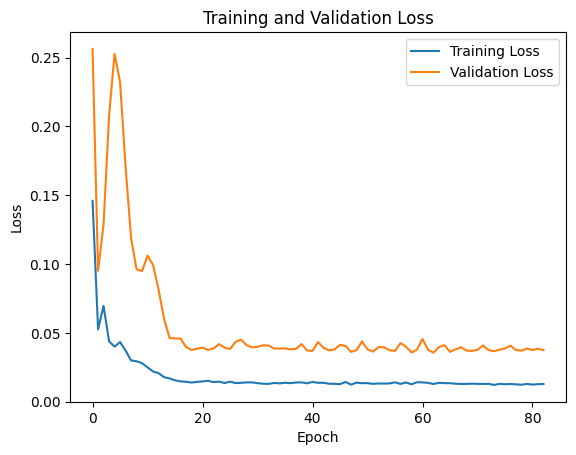

In [60]:
# Plot training and validation loss curves
def loss_curves(train_loss_history, val_loss_history):
    """
    Plot the training and validation loss curves for model performance evaluation.

    Arguments:
    train_loss_history : list : A list of training loss values at each epoch.
    val_loss_history   : list : A list of validation loss values at each epoch
    """

    # Plot training loss curve
    plt.plot(train_loss_history, label='Training Loss')

    # Plot validation loss curve
    plt.plot(val_loss_history, label='Validation Loss')

    # Add labels and title for the plot
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    # Display legend to differentiate between training and validation loss
    plt.legend()

    # Display the plot
    plt.show()

# TODO: Plot the training and validation loss curves
loss_curves(train_loss_history, val_loss_history)

# Plot true values vs. predictions

RNN RMSE: 61.5386


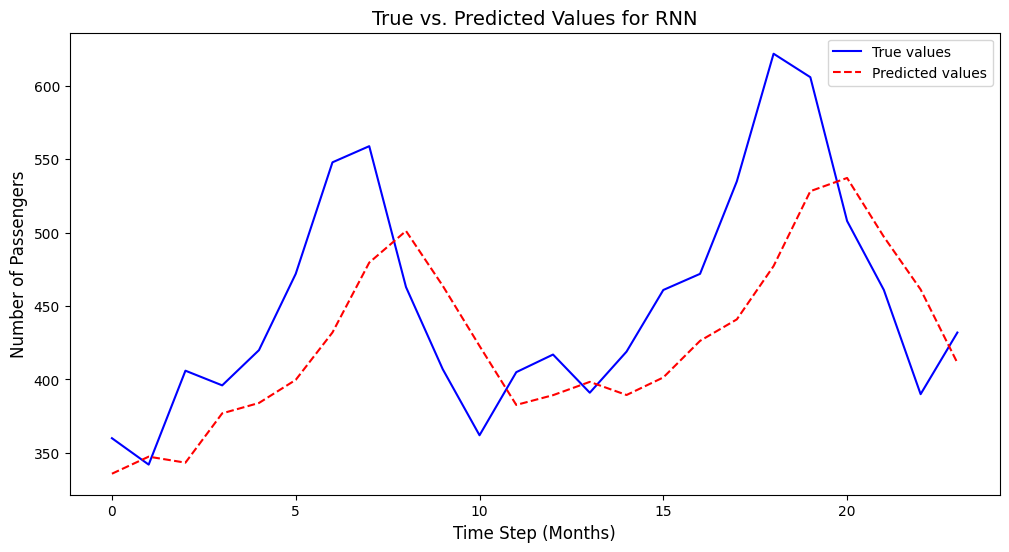

In [61]:
# Plot true values vs. predictions for the RNN model
def plot_true_pred(rnn_true, rnn_pred):
    """
    Plots the true values against the predicted values for visual comparison.
    Args:
        rnn_true (numpy array): The actual target values from the test set.
        rnn_pred (numpy array): The predicted values generated by the model.
    """
    # Set the figure size for better visualization
    plt.figure(figsize=(12, 6))

    # Plot the true values
    plt.plot(rnn_true, label='True values', color='blue', linestyle='-')

    # Plot the predicted values
    plt.plot(rnn_pred, label='Predicted values', color='red', linestyle='--')

    # Add title and labels
    plt.title('True vs. Predicted Values for RNN', fontsize=14)
    plt.xlabel('Time Step (Months)', fontsize=12)
    plt.ylabel('Number of Passengers', fontsize=12)

    # Show the legend for better understanding
    plt.legend()

    # Display the plot
    plt.show()

# TODO: Evaluate the RNN model on test data and get the true values and predictions
rnn_rmse, rnn_true, rnn_pred = evaluate_model(
    model=rnn_model,
    test_loader=test_loader,
    device=device,
    scaler=scaler
)

# Print RMSE for reference
print(f'RNN RMSE: {rnn_rmse:.4f}')

# TODO: Plot the true vs. predicted values
plot_true_pred(rnn_true, rnn_pred)


### Model Evaluation and Performance Visualization

In this cell, we evaluate the performance of the trained model across different data subsets (training, validation, and test). We use the `evaluate_model` function to compute the RMSE (Root Mean Squared Error) for each part.

By plotting the true values vs predictions for the training, validation, and test datasets, we can visually inspect how well the model performs on each part. Vertical lines are added to demonstrate the boundaries between the training, validation, and test data.

**Question:**

What do you expect to see in terms of the RMSE and the model’s performance on each dataset? How can you interpret the plot with respect to overfitting or underfitting?

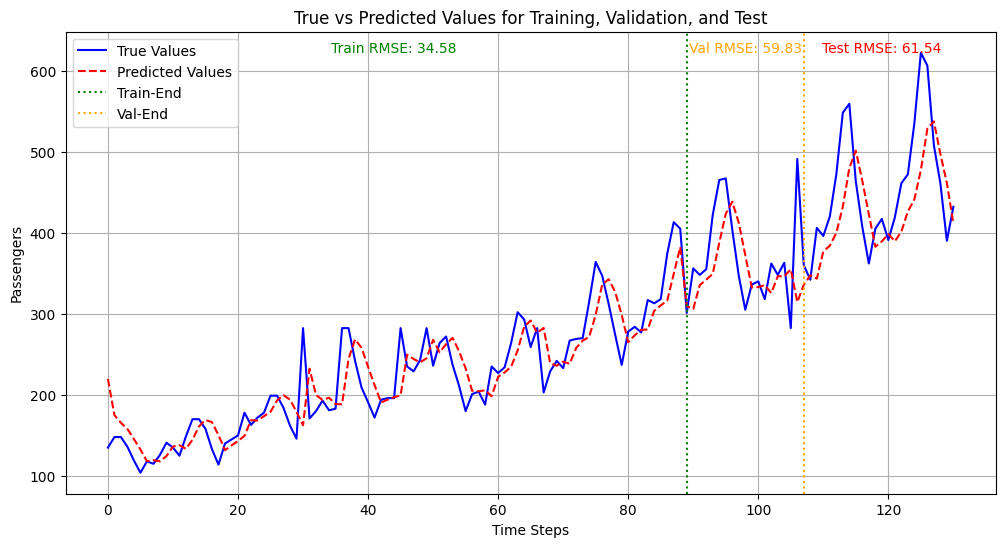

In [62]:
# Evaluate on each part: train, validation, and test
def evaluate_and_plot_with_rmse(model, train_loader, val_loader, test_loader, device, scaler):
    """
    This function evaluates the trained model on the training, validation, and test sets.
    It then concatenates the true and predicted values, and plots them along with RMSE values
    for each part (train, validation, and test).
    """

    # TODO: Evaluate on training data
    train_rmse, train_true, train_pred = evaluate_model(model, train_loader, device, scaler)

    # TODO: Evaluate on validation data
    val_rmse, val_true, val_pred = evaluate_model(model, val_loader, device, scaler)

    # TODO: Evaluate on test data
    test_rmse, test_true, test_pred = evaluate_model(model, test_loader, device, scaler)

    # Concatenate the true values and predicted values from all parts
    all_true = np.concatenate([train_true, val_true, test_true])
    all_pred = np.concatenate([train_pred, val_pred, test_pred])

    # Plotting setup
    plt.figure(figsize=(12, 6))

    # Plot true values vs predicted values (blue for true, red for predicted)
    plt.plot(all_true, label='True Values', color='blue')
    plt.plot(all_pred, label='Predicted Values', color='red', linestyle='--')

    # Add vertical lines to indicate the boundaries between train, validation, and test parts
    train_end = len(train_true)
    val_end = train_end + len(val_true)

    # Vertical lines separating train, validation, and test
    plt.axvline(x=train_end, color='green', linestyle=':', label='Train-End')
    plt.axvline(x=val_end, color='orange', linestyle=':', label='Val-End')

    # Display RMSE values for each section (train, val, test)
    plt.text(train_end // 2, max(all_true), f'Train RMSE: {train_rmse:.2f}', color='green', fontsize=10, ha='center')
    plt.text((train_end + val_end) // 2, max(all_true), f'Val RMSE: {val_rmse:.2f}', color='orange', fontsize=10, ha='center')
    plt.text((val_end + len(all_true)) // 2, max(all_true), f'Test RMSE: {test_rmse:.2f}', color='red', fontsize=10, ha='center')

    # Customize the plot (title, labels, legend, etc.)
    plt.title("True vs Predicted Values for Training, Validation, and Test")
    plt.xlabel("Time Steps")
    plt.ylabel("Passengers")
    plt.legend(loc='best')
    plt.grid(True)

    # Show the plot
    plt.show()

# Set up train DataLoader with shuffle=False (important for correct order in plotting)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Call the function to evaluate and plot
evaluate_and_plot_with_rmse(rnn_model, train_loader, val_loader, test_loader, device, scaler)


# Bonus: Compare the RNN RMSE with GRU

In this section, we will compare the performance of the RNN model with the GRU (Gated Recurrent Unit) model on the same dataset. We will evaluate both models using the Root Mean Squared Error (RMSE) and visualize the results.

The GRU is a more advanced variant of the RNN, designed to address some of the issues that vanilla RNNs face, such as vanishing gradients. We expect the GRU to potentially perform better in certain cases, especially when the sequence length is long or the dataset is complex.

By comparing the RMSE for both models (RNN and GRU), we can better understand how each model performs on the task at hand and which one is more suitable for time-series prediction.

Epoch [1/100], Train Loss: 0.0780, Validation Loss: 0.2884
Epoch [2/100], Train Loss: 0.0392, Validation Loss: 0.1734
Epoch [3/100], Train Loss: 0.0313, Validation Loss: 0.1105
Epoch [4/100], Train Loss: 0.0388, Validation Loss: 0.0911
Epoch [5/100], Train Loss: 0.0424, Validation Loss: 0.0959
Epoch [6/100], Train Loss: 0.0396, Validation Loss: 0.1118
Epoch [7/100], Train Loss: 0.0359, Validation Loss: 0.1285
Epoch [8/100], Train Loss: 0.0337, Validation Loss: 0.1383
Epoch [9/100], Train Loss: 0.0321, Validation Loss: 0.1379
Epoch [10/100], Train Loss: 0.0302, Validation Loss: 0.1281
Epoch [11/100], Train Loss: 0.0280, Validation Loss: 0.1129
Epoch [12/100], Train Loss: 0.0261, Validation Loss: 0.0970
Epoch [13/100], Train Loss: 0.0249, Validation Loss: 0.0839
Epoch [14/100], Train Loss: 0.0243, Validation Loss: 0.0753
Epoch [15/100], Train Loss: 0.0236, Validation Loss: 0.0709
Epoch [16/100], Train Loss: 0.0226, Validation Loss: 0.0690
Epoch [17/100], Train Loss: 0.0214, Validation Lo

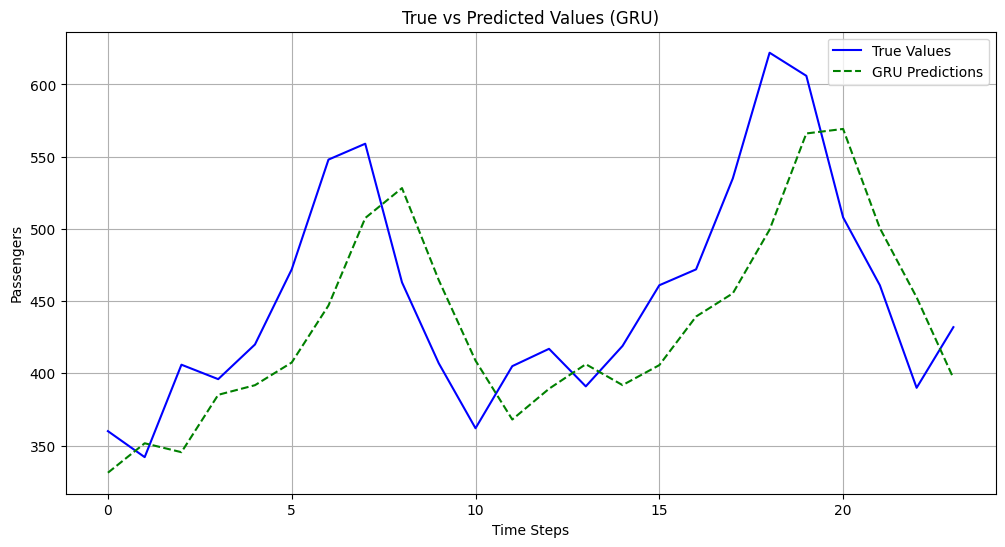

In [63]:
# Define GRU Model for Time Series Regression
class GRUModel(nn.Module):
    """
    A Gated Recurrent Unit (GRU) for time series regression.
    Predicts a single future value from a sequence of past values.
    """
    def __init__(self, input_size, hidden_size=20, num_layers=1, output_size=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # GRU forward pass
        out, _ = self.gru(x, h0)

        # Use the last time step output for prediction
        out = self.fc(out[:, -1, :])
        return out


# Initialize the GRU model
gru_model = GRUModel(input_size=X_train.shape[2], hidden_size=20, num_layers=1, output_size=1)

# Train the GRU model
gru_train_loss, gru_val_loss = train_model(
    gru_model,
    train_loader,
    val_loader=val_loader,
    epochs=100,
    learning_rate=0.004,
    device=device,
    patience=20
)

# Evaluate the GRU model on the test set
gru_rmse, gru_true, gru_pred = evaluate_model(
    model=gru_model,
    test_loader=test_loader,
    device=device,
    scaler=scaler
)

# Print and compare RMSEs
print(f"RNN RMSE: {rnn_rmse:.4f}")
print(f"GRU RMSE: {gru_rmse:.4f}")

# Optional: Plot true vs predicted for GRU
def plot_true_pred_gru(true_values, predicted_values):
    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label='True Values', color='blue')
    plt.plot(predicted_values, label='GRU Predictions', color='green', linestyle='--')
    plt.title("True vs Predicted Values (GRU)")
    plt.xlabel("Time Steps")
    plt.ylabel("Passengers")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_true_pred_gru(gru_true, gru_pred)
